<a href="https://colab.research.google.com/github/Jibrangit/DL_Assignments/blob/Experiment/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as Func
import scipy
import matplotlib.pyplot as plt
from torchvision.utils import save_image
%matplotlib inline 

In [89]:
INPUT = 784
HIDDEN = 256
BATCH_SIZE = 1
NUM_EPOCHS = 10
DATASET_SIZE = 100
LATENT_CODE_SIZE = 32
NUM_BATCHES = DATASET_SIZE//BATCH_SIZE
IMP_HYPERPARAM = 0.1                                                    #KL Divergence vs binary cross entropy loss, Increasing this favors the KL divergence 
DROPOUT = 0.99

In [90]:
class Encoder (nn.Module):    
  def __init__ (self):        
    super(Encoder, self).__init__()        # TODO initialize layers 
    self.hidden = nn.Linear(784, HIDDEN) 
    self.output = nn.Linear(HIDDEN, LATENT_CODE_SIZE)   
    self.dropout = nn.Dropout(p=DROPOUT)
    self.activation = nn.Tanh() 
    
  def forward (self, X):        
      # TODO execute layers and return result 
      # X = self.activation(X)
      # X = self.dropout(X)
      Z = self.hidden(X)
      Z = self.activation(Z)
      Z = self.dropout(Z)
      MU = self.output(Z)   
      SIGMA2 = self.output(Z)   
      SIGMA2 = torch.square(SIGMA2)     
      return MU, SIGMA2

class Decoder (nn.Module):    
  def __init__ (self):        
    super(Decoder, self).__init__()        
    # TODO initialize layers
    self.hidden = nn.Linear(LATENT_CODE_SIZE, HIDDEN) 
    self.output = nn.Linear(HIDDEN, 784)   
    self.dropout = nn.Dropout(p=DROPOUT)
    self.activation = nn.Tanh()   
    self.sigmoid_output = nn.Sigmoid()    
  
  def forward (self, Z):        
    # TODO execute layers and return result 
    X_re = self.hidden(Z)
    X_re = self.dropout(X_re)
    X_re = self.activation(X_re)
    X_re = self.output(X_re)   
    X_re = self.sigmoid_output(X_re)     
    return X_re

class VAE (nn.Module):    
  def __init__ (self):        
    super(VAE, self).__init__()        
    self.decoder = Decoder()        
    self.encoder = Encoder()
    # self.epsilon = torch.LongTensor(scipy.random.randn(LATENT_CODE_SIZE))

# Computes the hidden representation given the pre-sampled values eps    
  def latent_code (self, x):        
    mu, sigma2 = self.encoder(x)    
    # TODO extract mu and sigma2 from the code, and then use them and eps        
    # to compute z
    epsilon = torch.LongTensor(scipy.random.randn(LATENT_CODE_SIZE))
    sigma = torch.sqrt(sigma2) 
    mu = torch.sum(mu) / mu.shape[0]
    z =  mu.mul(epsilon) + sigma
    return z, mu, sigma2


  def recon_x (self, z):        
     x_re = self.decoder(z)        
     return x_re

def train (device, vae, x):
  optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

  losses = []
  def computeLoss (x): 
    # TODO implement your custom loss 
    z, mu, sigma2 = vae.latent_code(x)
    reconstructed_x = vae.recon_x(z)

    # print(f'Shape of x and reconstructed x: {x.shape}, {reconstructed_x.shape}')
    # BCE =  Func.binary_cross_entropy(reconstructed_x, x, reduction='sum') * (1/IMP_HYPERPARAM)
    BCE =  Func.binary_cross_entropy(reconstructed_x, x, reduction='mean') 
    # KLD = -0.5 * torch.sum(1 + torch.log(sigma2) - mu.pow(2) - sigma2.pow(2))
    KLD = 0

    Total_loss = BCE + KLD
    return Total_loss, z

  for e in range(NUM_EPOCHS):
    if e%2 == 0:
      print("Epoch: {}".format(e))
    for i in range(NUM_BATCHES):
      # Call computeLoss on each minibatch
      # print(f'On Minibatch# : {i}')
      miniBatch = X[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
      loss, z = computeLoss(miniBatch)         
      loss.backward()            
      optimizer.step()    

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
vae = VAE().to(device)    
X = torch.from_numpy(np.load("/content/drive/MyDrive/Colab Notebooks/DL_Assignments/HW7/mnist_train_images.npy")).float().to(device)   
X = X[0:DATASET_SIZE]
train(device, vae, X)

Epoch: 0
Epoch: 2
Epoch: 4
Epoch: 6
Epoch: 8


In [92]:
X_sample = X[0:16]
with torch.no_grad():
  z, m, s = vae.latent_code(X_sample)
  X_sample_pred = vae.decoder(z)

X_sample_show = (X_sample.reshape(X_sample.shape[0]*28, 28))
X_sample_pred = X_sample_pred.reshape(X_sample.shape[0]*28, 28)

X_comb = torch.hstack([X_sample_show, X_sample_pred])
print(X_sample_pred.shape)

torch.Size([448, 28])


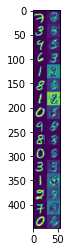

In [93]:
plt.imshow(X_comb)

In [94]:
z = torch.randn(16, LATENT_CODE_SIZE)

X_sample = X[0:16]
with torch.no_grad():
  X_sample_random = vae.decoder(z)

X_sample_random = X_sample_pred.reshape(X_sample.shape[0]*28, 28)


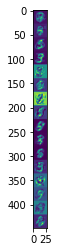

In [95]:
plt.imshow(X_sample_random)